# 1. Objective
Train a convolutional neural network (CNN) to recognize handwritten digits from the MNIST dataset. The training process will involve image augmentations to improve the robustness of the model, and model performance will be evaluated.



# 2. Setup
Set up the environment by importing the necessary libraries. Also fix a random “seed” so results are reproducible (always the same each run), and define where the trained model will be saved.

In [ ]:
import os
import random
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
import albumentations as A
import cv2

In [ ]:
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
MODEL_PATH = "mnist_cnn_albu.keras"

# 3. Load MNIST Dataset
Load the MNIST dataset of handwritten digits, splitting it into training and testing sets. Convert the images to decimal values between 0 and 1 for easier processing, and add an extra dimension to represent that they are grayscale images. Finally, display the shape and data type of the training and test sets.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = (x_train.astype("float32")/255.0)[..., np.newaxis]
x_test  = (x_test.astype("float32")/255.0)[..., np.newaxis]

print("x_train:", x_train.shape, x_train.dtype, " | x_test:", x_test.shape)

x_train: (60000, 28, 28, 1) float32  | x_test: (10000, 28, 28, 1)


Show random sample of the dataset

In [ ]:
def show_random_grid(images, labels, n=36, cols=6, title="Random sample"):
    idxs = np.random.choice(len(images), size=n, replace=False)
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i, idx in enumerate(idxs, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(images[idx].squeeze(), cmap="gray"); plt.title(f"y={labels[idx]}", fontsize=9)
        plt.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

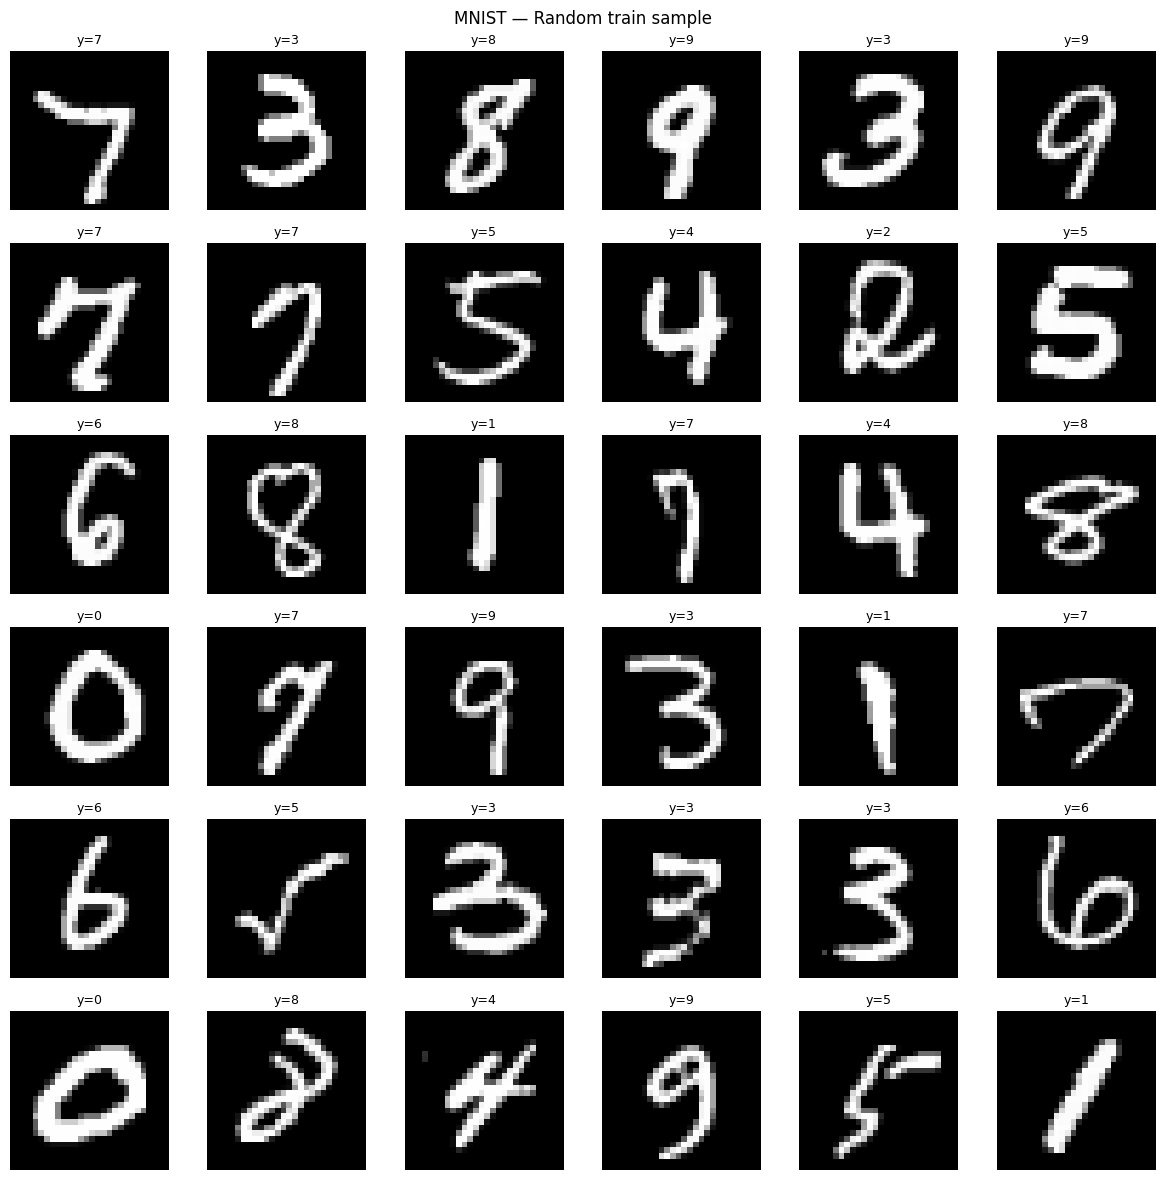

In [ ]:
show_random_grid(x_train, y_train, n=36, cols=6, title="MNIST — Random train sample")

# 4. Data Augmentation
Define data augmentation rules to slightly modify the training images of digits. These transformations include shifting, scaling, rotating, shearing, and adding distortions, which create varied versions of the digits. The goal is to make the model more robust by teaching it to recognize numbers even when they appear with small changes or imperfections.

In [ ]:
# Train-time augmentations (gentle for 28x28 digits)
albu_train = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.08,
        scale_limit=0.12,
        rotate_limit=12,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        interpolation=cv2.INTER_LINEAR,
        p=0.90
    ),
    A.Affine(
        shear={"x": (-10, 10), "y": (-10, 10)},
        cval=0,
        mode=cv2.BORDER_CONSTANT,
        interpolation=cv2.INTER_LINEAR,
        p=0.50
    ),
    A.OneOf([
        A.ElasticTransform(
            alpha=12,
            sigma=4,
            alpha_affine=8,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=1.0
        ),
        A.GridDistortion(
            num_steps=5,
            distort_limit=0.08,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=1.0
        ),
        A.CropAndPad(
            percent=(-0.05, 0.05),
            pad_mode=cv2.BORDER_CONSTANT,
            pad_cval=0,
            keep_size=True,
            p=1.0
        ),
    ], p=0.35),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3025530403.py:3: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipython-input-3025530403.py:12: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(
/tmp/ipython-input-3025530403.py:20: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipython-input-3025530403.py:28: UserWarning: Argument(s) 'value' are not valid for transform GridDistortion
  A.GridDistortion(
/tmp/ipython-input-3025530403.py:35: UserWarning: Argument(s) 'pad_mode, pad_cval' are not valid for transform CropAndPad
  A.CropAndPad(


Create a custom data loader that feeds the model mini-batches of images and labels, shuffling them each epoch and applying the Albumentations transformations on-the-fly. Convert each 28×28 grayscale image to the right format and scale, augment it if a transform is provided (so new variations are generated during training but not saved), and return a stacked batch of images with their corresponding labels.

In [ ]:
# Keras Sequence applying Albumentations on-the-fly
class AlbuSequence(keras.utils.Sequence):
    def __init__(self, x, y, batch_size=128, shuffle=True, transform=None):
        self.x, self.y = x, y
        self.batch_size, self.shuffle, self.transform = batch_size, shuffle, transform
        self.indexes = np.arange(len(self.x)); self.on_epoch_end()
    def __len__(self): return int(np.ceil(len(self.x)/self.batch_size))
    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indexes)
    def __getitem__(self, i):
        idxs = self.indexes[i*self.batch_size:(i+1)*self.batch_size]
        bx, by = [], self.y[idxs]
        for idx in idxs:
            img = self.x[idx]  # (28,28,1), [0,1]
            if self.transform is not None:
                img_u8 = np.clip(img*255.0,0,255).astype(np.uint8).squeeze()
                aug = self.transform(image=img_u8)["image"].astype(np.float32)/255.0
                aug = aug[..., np.newaxis]
                bx.append(aug)
            else:
                bx.append(img.astype(np.float32))
        return np.stack(bx,0), by

Visual demo: pick one test image and show 1 original + 8 augmented

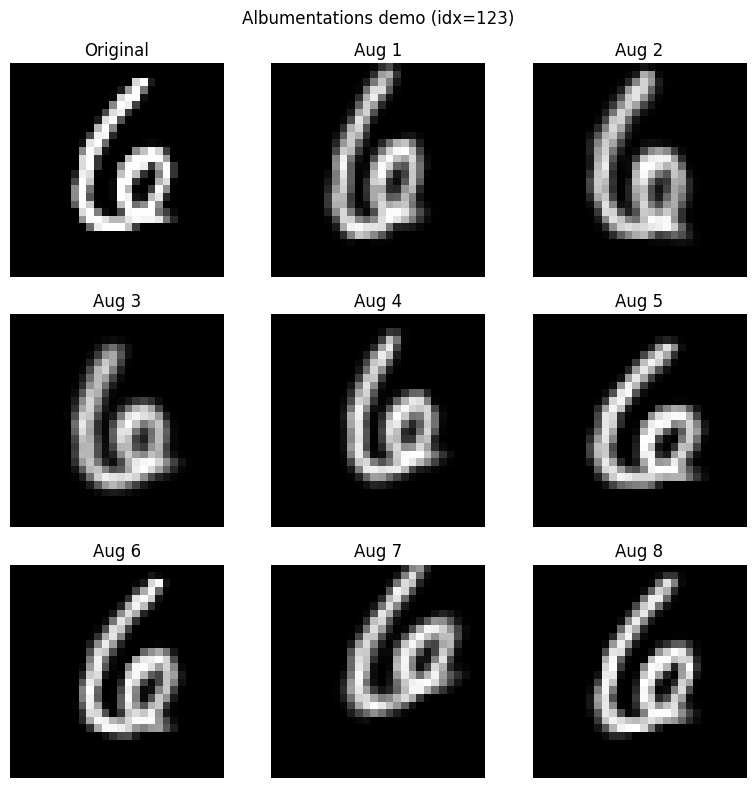

In [ ]:
idx_demo = 123
base_img = (x_test[idx_demo].squeeze()*255).astype(np.uint8)
plt.figure(figsize=(8,8))
plt.subplot(3,3,1); plt.imshow(base_img, cmap="gray"); plt.title("Original"); plt.axis("off")
for k in range(2,10):
    aug = albu_train(image=base_img)["image"]
    plt.subplot(3,3,k); plt.imshow(aug, cmap="gray"); plt.title(f"Aug {k-1}"); plt.axis("off")
plt.suptitle(f"Albumentations demo (idx={idx_demo})"); plt.tight_layout(); plt.show()

# 5. Define CNN model

Build a convolutional neural network (CNN) that learns visual patterns from 28×28 grayscale digit images. Two feature-extraction blocks use convolution layers (32 then 64 filters) with batch normalization and max pooling to capture edges and shapes while reducing image size; dropout helps prevent overfitting. The extracted features are flattened and passed to dense layers, ending with a 10-unit softmax layer that outputs the probability of each digit class (0–9).

In [ ]:
inputs = layers.Input(shape=(28,28,1))

# Conv Block 1: 32 Filters
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)

# Conv Block 2: 64 Filters
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)

# Classifier block
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="mnist_cnn")

Configure the model for training by choosing the Adam optimizer to adjust weights, a loss function suited for multi-class classification, and accuracy as the main performance metric. Display a summary of the model architecture, showing each layer, the number of parameters, and how data flows through the network.

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "mnist_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,202 (1.79 MB)

 Trainable params: 468,010 (1.79 MB)

 Non-trainable params: 192 (768.00 B)

Plot model architecture

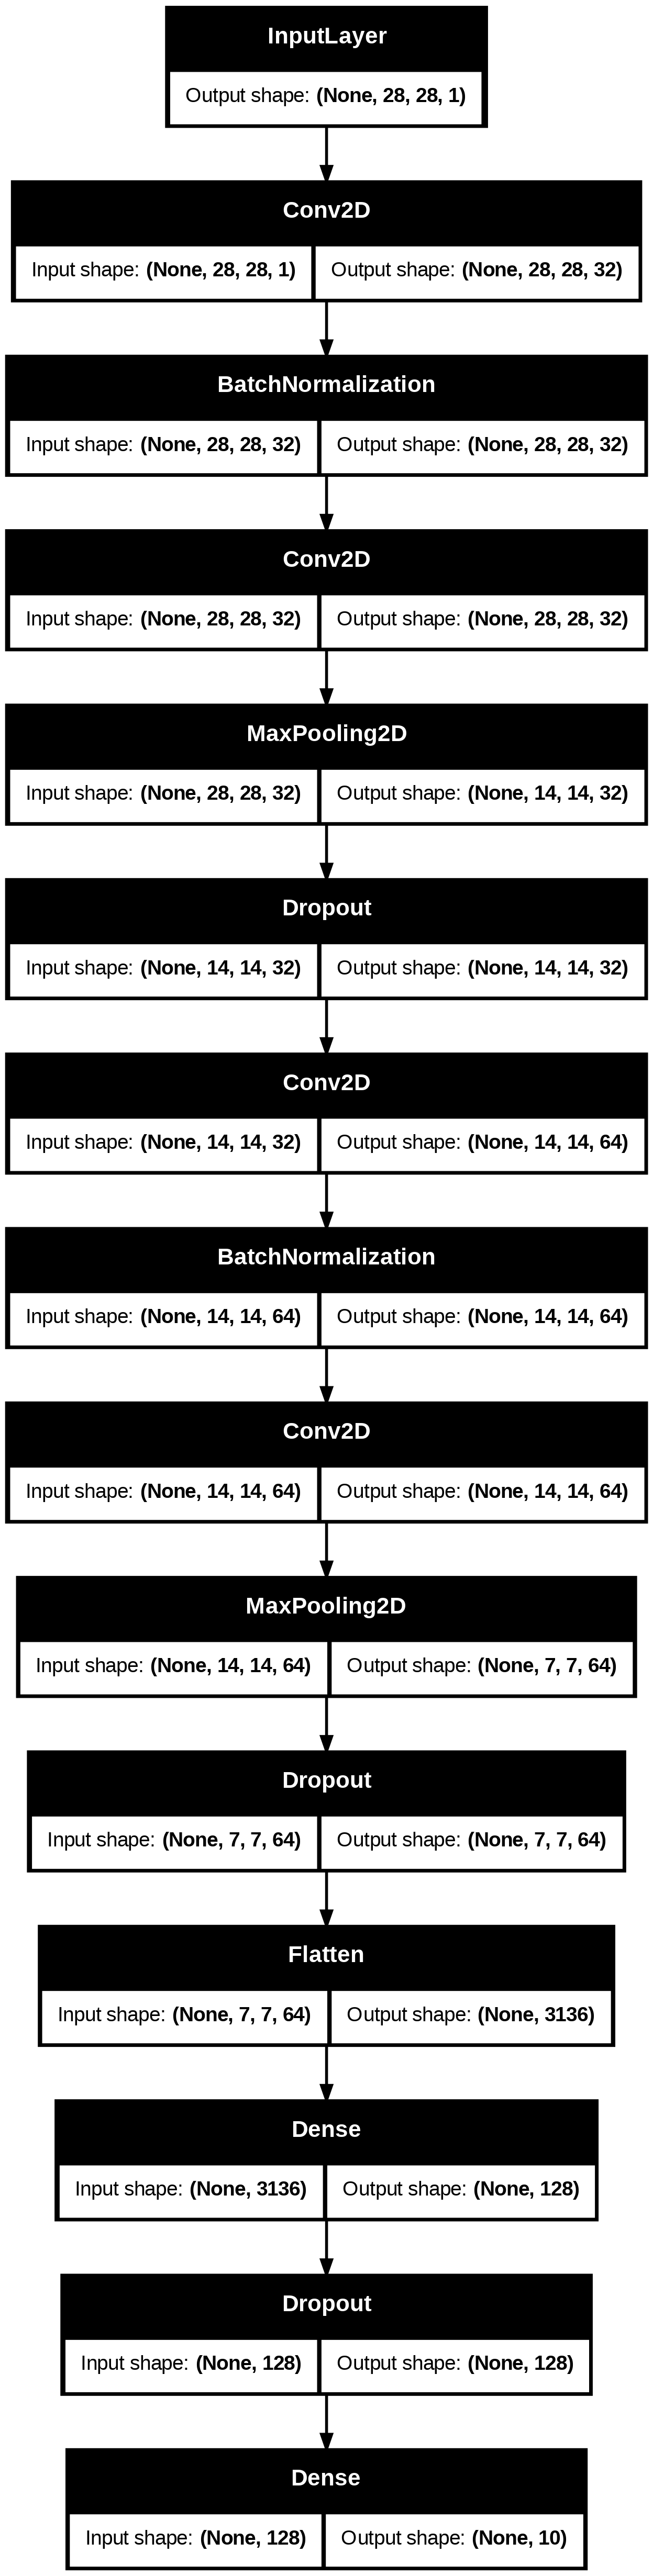

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

Install extra libraries to create a visual diagram of the neural network. Use visualkeras and graphviz to generate an image that shows the model layer by layer, making it easier to understand the structure and how data flows through the network.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


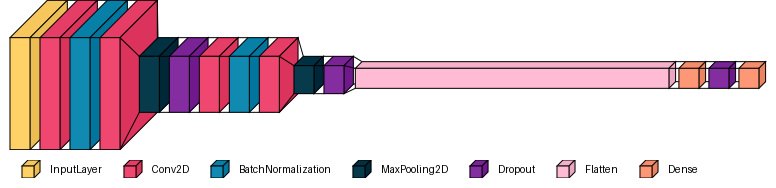

In [ ]:
# Install dependencies
!pip install -q visualkeras
# For graph view (optional)
!apt-get -qq install -y graphviz > /dev/null
!pip install -q graphviz

import visualkeras
from tensorflow.keras import layers
from IPython.display import Image, display

# Layered (blocks)
img = visualkeras.layered_view(model, legend=True, draw_volume=True).convert("RGB")
img.save("model_layered.png")

from IPython.display import Image, display
display(Image("model_layered.png"))


# 6. Train + Validate

Train the model using the augmented training data and validate it on the test set. Mini-batches are created with the custom data loader, while callbacks save the best model automatically and stop training early if validation accuracy stops improving. The training process can run up to 100 epochs, but it may finish sooner if performance levels off.

In [ ]:
train_seq = AlbuSequence(x_train, y_train, batch_size=128, shuffle=True, transform=albu_train)
val_seq   = AlbuSequence(x_test,  y_test,  batch_size=128, shuffle=False, transform=None)

ckpt = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH, monitor="val_accuracy", save_best_only=True, verbose=1)
early = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

history = model.fit(train_seq, validation_data=val_seq, epochs=100, callbacks=[ckpt, early], verbose=1)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6175 - loss: 1.1551
Epoch 1: val_accuracy improved from -inf to 0.97260, saving model to mnist_cnn_albu.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.6179 - loss: 1.1541 - val_accuracy: 0.9726 - val_loss: 0.1451
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9141 - loss: 0.2798
Epoch 2: val_accuracy improved from 0.97260 to 0.98800, saving model to mnist_cnn_albu.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.9141 - loss: 0.2797 - val_accuracy: 0.9880 - val_loss: 0.0390
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9466 - loss: 0.1835
Epoch 3: val_accuracy improved from 0.98800 to 0.99200, saving model to mnist_cnn_albu.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.9466 - loss: 0.1835 - val_accuracy: 0.9920 - val_loss: 0.0268
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9587 - loss: 0.1382
Epoch 4: val_accuracy did n

# 7. Evaluate trained model

Evaluate the performance of the trained model on the test dataset to measure how well it recognizes unseen handwritten digits.

## Loss and accuracy curves

Plot the training and validation loss and accuracy across epochs to visualize learning progress and spot overfitting (when training improves but validation stalls or worsens). Lower loss and higher accuracy indicate better performance; the two curves should track closely if the model is generalizing well.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history, figsize=(8, 8), suptitle="Training & Validation Curves"):
    """Plot loss (top) and accuracy (bottom) from a Keras History."""
    H = history.history
    # keys fallback
    acc_key = "accuracy" if "accuracy" in H else ("acc" if "acc" in H else None)
    val_acc_key = "val_accuracy" if "val_accuracy" in H else ("val_acc" if "val_acc" in H else None)
    if acc_key is None or val_acc_key is None:
        raise KeyError("Accuracy keys not found in history (expected 'accuracy'/'val_accuracy' or 'acc'/'val_acc').")
    if "loss" not in H or "val_loss" not in H:
        raise KeyError("Loss keys not found in history (expected 'loss' and 'val_loss').")

    epochs = np.arange(1, len(H["loss"]) + 1)

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    fig.suptitle(suptitle, fontsize=14)

    # Loss (top)
    axes[0].plot(epochs, H["loss"], label="train_loss")
    axes[0].plot(epochs, H["val_loss"], label="val_loss")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss curve")
    axes[0].grid(True, linestyle="--", alpha=0.4)
    axes[0].legend(loc="best")

    # Accuracy (bottom)
    axes[1].plot(epochs, H[acc_key], label="train_acc")
    axes[1].plot(epochs, H[val_acc_key], label="val_acc")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy curve")
    axes[1].grid(True, linestyle="--", alpha=0.4)
    axes[1].legend(loc="best")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


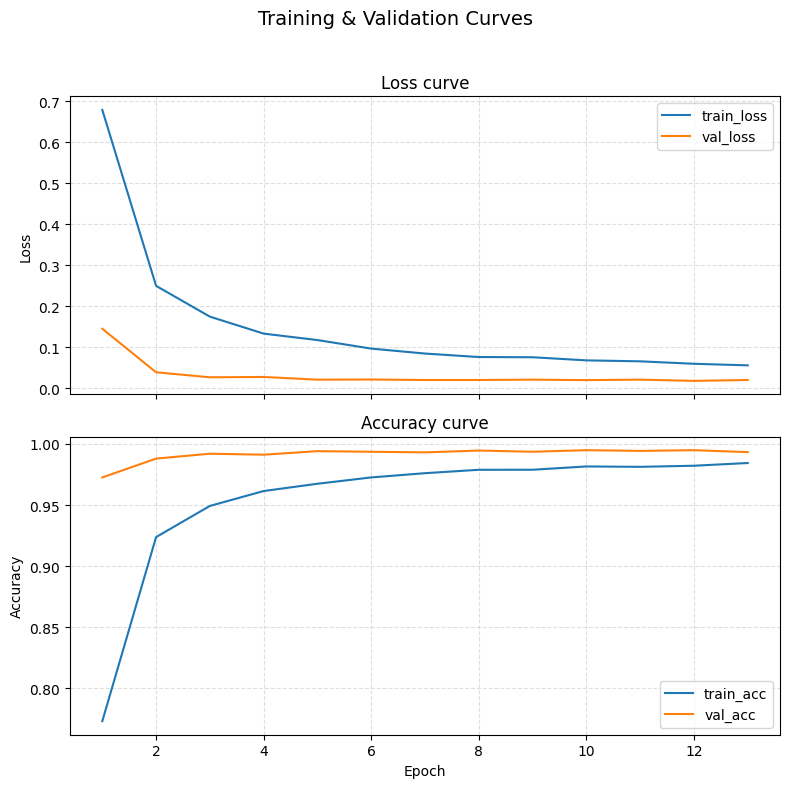

In [ ]:
plot_loss_and_accuracy(history)

Measure the model’s performance on the test set by calculating its loss and accuracy. The results show very low error (loss = 0.0199) and very high accuracy (99.49%), meaning the network correctly recognizes almost all handwritten digits it has never seen before.

In [ ]:
# Evaluate trained model
test_loss, test_acc = model.evaluate(val_seq, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.0199 | Test Acc: 0.9949


## Confusion Matrix

Generate predictions on the test images and compare them with the true labels using a confusion matrix. The left chart shows the number of times each digit was correctly or incorrectly classified, while the right chart shows the same information normalized (as percentages). This makes it easy to see which digits the model confuses most often. A detailed classification report is also printed, giving precision, recall, and F1-score for each digit.

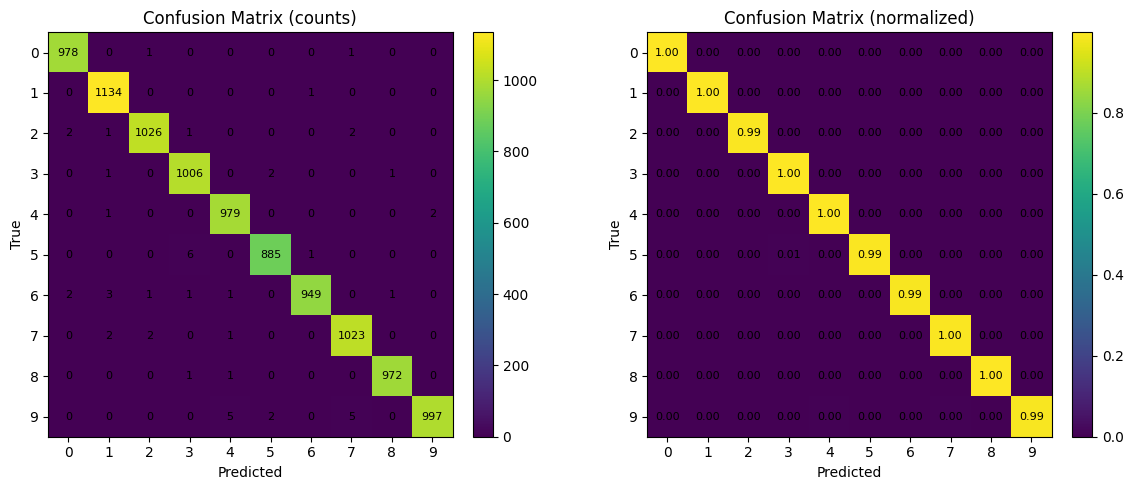


Classification report:
               precision    recall  f1-score   support

           0     0.9959    0.9980    0.9969       980
           1     0.9930    0.9991    0.9960      1135
           2     0.9961    0.9942    0.9952      1032
           3     0.9911    0.9960    0.9936      1010
           4     0.9919    0.9969    0.9944       982
           5     0.9955    0.9922    0.9938       892
           6     0.9979    0.9906    0.9942       958
           7     0.9922    0.9951    0.9937      1028
           8     0.9979    0.9979    0.9979       974
           9     0.9980    0.9881    0.9930      1009

    accuracy                         0.9949     10000
   macro avg     0.9950    0.9948    0.9949     10000
weighted avg     0.9949    0.9949    0.9949     10000



In [ ]:
# predictions on test
probs_test = model.predict(x_test, batch_size=256, verbose=0)
y_pred = probs_test.argmax(axis=1)

# confusion matrices
cm = confusion_matrix(y_test, y_pred, labels=range(10))
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

# --- Matplotlib (counts + normalized, with cell text) ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(range(10)); ax[0].set_yticks(range(10))
for i in range(10):
    for j in range(10):
        ax[0].text(j, i, int(cm[i, j]), ha='center', va='center', fontsize=8)
cbar0 = fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(cm_norm, interpolation='nearest')
ax[1].set_title("Confusion Matrix (normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(range(10)); ax[1].set_yticks(range(10))
for i in range(10):
    for j in range(10):
        ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha='center', va='center', fontsize=8)
cbar1 = fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout(); plt.show()

print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# 8. Save and Reload model

Save the trained model to disk so it can be reused later without retraining. Reload the model from the saved file, show its structure to confirm it is intact, and run a quick prediction on one test image as a sanity check to verify that the reloaded model works the same as the original.

In [ ]:
model.save(MODEL_PATH)
print(f"Model saved at: {MODEL_PATH}")

reloaded = keras.models.load_model(MODEL_PATH)
print("Reloaded model summary:")
reloaded.summary()

# Sanity check prediction after reload
p0 = reloaded.predict(x_test[0:1], verbose=0)[0]
print("Example probs (test[0]):", np.round(p0, 3), " | argmax:", int(np.argmax(p0)))

Model saved at: mnist_cnn_albu.keras
Reloaded model summary:


Model: "mnist_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,404,224 (5.36 MB)

 Trainable params: 468,010 (1.79 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 936,022 (3.57 MB)

Example probs (test[0]): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]  | argmax: 7


# 9. Test the model
Pick a test image, display it, and show the model's prediction, along with ahorizontal bar chart of probabilities for all digits (0-9).

In [ ]:
def plot_probs(test_index):
  img = x_test[test_index]            # (28,28,1), [0,1]
  true_label = int(y_test[test_index])
  probs = reloaded.predict(img[np.newaxis, ...], verbose=0)[0]
  pred_label = int(np.argmax(probs))
  print(f"idx={test_index} | y_true={true_label} | y_pred={pred_label}")

  plt.figure(figsize=(3,3))
  plt.imshow(img.squeeze(), cmap="gray"); plt.title(f"idx={test_index} | true={true_label} | pred={pred_label}")
  plt.axis("off"); plt.tight_layout(); plt.show()

  digits = [str(i) for i in range(10)]  # fixed order 0..9
  fig = go.Figure()
  fig.add_trace(go.Bar(
      x=probs, y=digits, orientation="h",
      hovertemplate='Digit %{y}: %{x:.4f}<extra></extra>'
  ))
  fig.update_layout(
      title=f"Class probabilities (idx={test_index}, pred={pred_label})",
      xaxis_title="Probability", yaxis_title="Digit",
      yaxis=dict(categoryorder="array", categoryarray=digits),
      margin=dict(l=80, r=40, t=60, b=40), bargap=0.15
  )
  fig.show()

idx=1234 | y_true=8 | y_pred=8


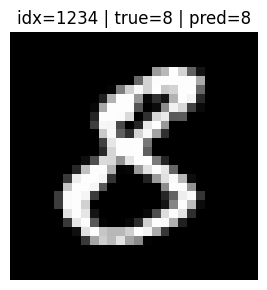

In [ ]:
test_index = 1234
plot_probs(test_index)